# toyproblem no.3 --> Alternative optima! 
This poblem is used to see if chemical consitence was given in teh first problem. A real chemical network is used here. This was assembled manually.

species=5
reactions=6


3. A-->2B
4. 2B--> A
5. A+C --> D
6. D --> A+C
7. D--> B+E
8. B+E --> A+C

[-1,1,-1,1,0,1]
[2,-2,0,0,1,-1]
[0,0,-1,1,0,1] 
[0,0,1,-1,-1,0]
[0,0,0,0,1,-1]

## Problem of finding alternative solutions
If given: 100 mol A and 100 mol C. Assuming all reactions have the same cost and one can only sell B for 5£/mol and D for 10£/mol. 
Both reaction 1 (A --> 2B) and reaction 5 (A+C --> D) would be optimal solutions with the same objective value.<br>
### How to implement the enumeration of all alternative optima? 

In [44]:
import pulp 
from pulp import *
import numpy as np
import pandas as pd
from IPython.display import IFrame
import pickle
import matplotlib.pyplot as plt
IFrame("prob_02_28.png", width=600, height=300)

### Providing steady-state conditions
Flux Balance Analysis was previously used in metabolic networks, where the assumption holds that incoming outgoing fluxes at each node cancel each other out, resulting in a steady-state assumption. For the reaction network we need to artifically create that steady-state assumption by considering the overall supply chain. Hence, we introduce a supply and a removal term to the formulation, leadimg to an overall system in steady-state.
<br>Hence, we have: <br> \begin{equation}A_1 \cdot f_1 + A_2 \cdot f_2 -A_3\cdot f_3 =0 \end{equation} <br> where $A_1$ is the supply matrix with pseudoreactions, $A_2$ is the stoichiometric matrix and $A_3$ is the removal matrix with pseudoreactions. $f_1$, $f_2$, and $f_3$ are the fluxes going through the sets of reactions in the respective system (supply, reaction, removal).

In [26]:
master=2
A1= np.array([[1,0],[0,0],[0,1],[0,0],[0,0]])
if master==2:
    print("Supply matrix:")
    print(pd.DataFrame(A1,
                      index=["A","B","C",'D',"E"],
                      columns=["S_R_1","S_R_2"]))


A2=np.array([[-1,1,-1,1,0,1],[2,-2,0,0,1,-1],[0,0,-1,1,0,1] ,[0,0,1,-1,-1,0],[0,0,0,0,1,-1]])
if master==2:
    print("Stoichiometric matrix:")
    print(pd.DataFrame(A2,
                      index=["A","B","C",'D',"E"],
                      columns=["R_1","R_2","R_3","R_4","R_5","R_6"]))

A3=np.array([[1,0,0,0,0],[0,1,0,0,0],[0,0,1,0,0],[0,0,0,1,0],[0,0,0,0,1]])
if master==2:
    print("Removal matrix:")
    print(pd.DataFrame(A3,
                      index=["A","B","C",'D',"E"],
                      columns=["R_R_1","R_R_2","R_R_3","R_R_4","R_R_5"]))

Supply matrix:
   S_R_1  S_R_2
A      1      0
B      0      0
C      0      1
D      0      0
E      0      0
Stoichiometric matrix:
   R_1  R_2  R_3  R_4  R_5  R_6
A   -1    1   -1    1    0    1
B    2   -2    0    0    1   -1
C    0    0   -1    1    0    1
D    0    0    1   -1   -1    0
E    0    0    0    0    1   -1
Removal matrix:
   R_R_1  R_R_2  R_R_3  R_R_4  R_R_5
A      1      0      0      0      0
B      0      1      0      0      0
C      0      0      1      0      0
D      0      0      0      1      0
E      0      0      0      0      1


We can reformulate the problem to: $A'\cdot f' = b $ where:<br>
\begin{equation}A'=\begin{bmatrix} A_1 A_2 \end{bmatrix}, \; f'=\begin{bmatrix} f_1 \\ f_2
\end{bmatrix}, \;
b = A_3\cdot f_3
\end{equation}

## Optimisation problem 
The optimisation problem is a linear programming problem described by the degrees of freedom (DoF), the constraints, and the target function. The problem can be formulated as:<br>
\begin{equation}
\begin{aligned}
& \underset{f',b}{\text{min}}
& & \phi_{price} \\
& \text{subject to}
& & A'\cdot f'=b, \; f_{1,1} = 100, \; f_{1,2}= 100 
\end{aligned}
\end{equation}<br>

It makes sense to either constrain the supply to the network ($f_{1,1}$ and $f_{1,2}$) or to demand a specifiy output/removal as in ($b_{i}=x$). In this example we have constraint the supply. Hence, the question is: Given that supply of component A and B how can we maximise profit. 


### Target function 
We use a cost function, where each reaction flux is taxed by a specific price and a profit that you earn by selling end products.
<br>\begin{equation}
\begin{aligned}
\phi_{price}=C_r^T\cdot f'- P_s^T \cdot b
\end{aligned}
\end{equation}<br>
where $\phi_{price}$ is the target function, $C_r^T$ is the cost of each reaction flux, $P_s^T$ is the selling price for each end product, $f'$ is the vector of fluxes through thr reactions and $b$ are the resulting fluxes per species.

In [43]:
Cr=np.array([0,0,1,1,1,1,1,1])
Ps=np.array([0,-5,0,-10,0])
Cost=np.concatenate((Cr,Ps))
print("Cost of reaction")
print(Cr)
print("Selling price")
print(Ps)
print("total cost")
print(Cost)

Cost of reaction
[0 0 1 1 1 1 1 1]
Selling price
[  0  -5   0 -10   0]
total cost
[  0   0   1   1   1   1   1   1   0  -5   0 -10   0]


In [40]:
A=np.concatenate((A1,A2,(-A3)),axis=1)
A_additional_constraints=np.array([[1,0,0,0,0,0,0,0,0,0,0,0,0],[0,1,0,0,0,0,0,0,0,0,0,0,0]])

f1=[]
for k in range(1,3):
    f1.append("f1_{0}".format(k))
f2=[]
for k in range(1,7):
    f2.append("f2_{0}".format(k))
b=[]
for k in range(1,6):
    b.append("b_{0}".format(k))
f_names=f1+f2+b
print(f_names)
print(A)


cost={}
ob=Cost
for i in range(0,len(ob)):
    cost[f_names[i]]=ob[i]
    
print(cost)

C1={}
C2={}
C3={}
C4={}
C5={}
C6={}

matrix_constraints=[C1,C2,C3,C4,C5]
for i in range(0,len(ob)):
    C1[f_names[i]]=A[0][i]
    C2[f_names[i]]=A[1][i]
    C3[f_names[i]]=A[2][i]
    C4[f_names[i]]=A[3][i]
    C5[f_names[i]]=A[4][i]


C6={}
C7={}

additional_constraints=[C6,C7]
for i in range(0,len(ob)):
    C6[f_names[i]]=A_additional_constraints[0][i]
    C7[f_names[i]]=A_additional_constraints[1][i]

    



prob=LpProblem("FBA_toy",LpMinimize)


flux_vars = LpVariable.dicts("Flux",f_names,0)

prob += lpSum([cost[i]*flux_vars[i] for i in f_names])

for n in matrix_constraints:
    prob += lpSum([n[i] * flux_vars[i] for i in f_names]) == 0
for n in additional_constraints:
    prob += lpSum([n[i] * flux_vars[i] for i in f_names]) == 100

prob

['f1_1', 'f1_2', 'f2_1', 'f2_2', 'f2_3', 'f2_4', 'f2_5', 'f2_6', 'b_1', 'b_2', 'b_3', 'b_4', 'b_5']
[[ 1  0 -1  1 -1  1  0  1 -1  0  0  0  0]
 [ 0  0  2 -2  0  0  1 -1  0 -1  0  0  0]
 [ 0  1  0  0 -1  1  0  1  0  0 -1  0  0]
 [ 0  0  0  0  1 -1 -1  0  0  0  0 -1  0]
 [ 0  0  0  0  0  0  1 -1  0  0  0  0 -1]]
{'f1_1': 0, 'f1_2': 0, 'f2_1': 1, 'f2_2': 1, 'f2_3': 1, 'f2_4': 1, 'f2_5': 1, 'f2_6': 1, 'b_1': 0, 'b_2': -5, 'b_3': 0, 'b_4': -10, 'b_5': 0}


FBA_toy:
MINIMIZE
-5*Flux_b_2 + -10*Flux_b_4 + 1*Flux_f2_1 + 1*Flux_f2_2 + 1*Flux_f2_3 + 1*Flux_f2_4 + 1*Flux_f2_5 + 1*Flux_f2_6 + 0
SUBJECT TO
_C1: - Flux_b_1 + Flux_f1_1 - Flux_f2_1 + Flux_f2_2 - Flux_f2_3 + Flux_f2_4
 + Flux_f2_6 = 0

_C2: - Flux_b_2 + 2 Flux_f2_1 - 2 Flux_f2_2 + Flux_f2_5 - Flux_f2_6 = 0

_C3: - Flux_b_3 + Flux_f1_2 - Flux_f2_3 + Flux_f2_4 + Flux_f2_6 = 0

_C4: - Flux_b_4 + Flux_f2_3 - Flux_f2_4 - Flux_f2_5 = 0

_C5: - Flux_b_5 + Flux_f2_5 - Flux_f2_6 = 0

_C6: Flux_f1_1 = 100

_C7: Flux_f1_2 = 100

VARIABLES
Flux_b_1 Continuous
Flux_b_2 Continuous
Flux_b_3 Continuous
Flux_b_4 Continuous
Flux_b_5 Continuous
Flux_f1_1 Continuous
Flux_f1_2 Continuous
Flux_f2_1 Continuous
Flux_f2_2 Continuous
Flux_f2_3 Continuous
Flux_f2_4 Continuous
Flux_f2_5 Continuous
Flux_f2_6 Continuous

In [41]:
status=prob.solve()
LpStatus[status]

'Optimal'

-900.0
{Flux_f1_1: 100.0, Flux_f1_2: 100.0, Flux_f2_1: 100.0, Flux_f2_2: 0.0, Flux_f2_3: -0.0, Flux_f2_4: 0.0, Flux_f2_5: 0.0, Flux_f2_6: 0.0, Flux_b_1: 0.0, Flux_b_2: 200.0, Flux_b_3: 100.0, Flux_b_4: 0.0, Flux_b_5: 0.0}


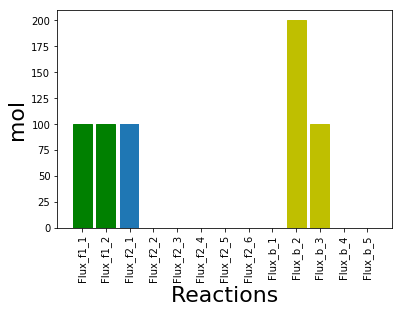

In [42]:
print(value(prob.objective))
results_dic_1={}
for i in f_names:
    results_dic_1[flux_vars[i]]=value(flux_vars[i])
print(results_dic_1)
plt.clf()
barlist=plt.bar(range(len(results_dic_1)), list(results_dic_1.values()), align='center')
plt.xticks(range(len(results_dic_1)), list(results_dic_1.keys()),rotation='vertical')
plt.xlabel("Reactions",fontsize=22)
plt.ylabel("mol",fontsize=22)
barlist[0].set_color('g')
barlist[1].set_color('g')
barlist[8].set_color('y')
barlist[9].set_color('y')
barlist[10].set_color('y')
barlist[11].set_color('y')
barlist[12].set_color('y')


plt.savefig("toyproblem_problem1.pdf", bbox_inches = 'tight')
plt.show()